In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller

In [2]:
def download_data(ticker, start_date="2014-01-01"):
    # download ticker data from yfinance library
    df = yf.download(ticker, start=start_date)
    df.dropna(inplace=True)
    return df

# Download data
ticker1 = "KO"
ticker2 = "PEP"
df_ko = download_data(ticker1)
df_pep = download_data(ticker2)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
df_ko.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,41.119999,41.230000,40.509998,40.660000,29.140579,12698600
2014-01-03,40.680000,40.730000,40.349998,40.459999,28.997238,10403400
2014-01-06,40.480000,40.590000,40.160000,40.270000,28.861071,11036300
2014-01-07,40.480000,40.720001,40.290001,40.389999,28.947079,11872300
2014-01-08,40.439999,40.439999,39.830002,39.939999,28.624557,15339600


In [4]:
df_pep.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,82.930000,82.989998,81.820000,82.099998,60.635113,3275900
2014-01-03,82.120003,82.870003,82.120003,82.239998,60.738506,3287200
2014-01-06,82.199997,82.610001,82.080002,82.279999,60.768051,3888400
2014-01-07,82.620003,83.989998,82.610001,83.480003,61.654312,6332400
2014-01-08,83.330002,83.620003,82.809998,83.239998,61.477051,5653300


In [5]:
def prepare_time_series(data1, data2, ticker1, ticker2, index_ticker="SPY"):
    # download index data
    index_data = download_data(index_ticker)

    # among the 3 dataframes: determine latest start date and trim all dataframes to start there
    latest_start_date = max(data1.index.min(), data2.index.min(), index_data.index.min())
    data1 = data1[data1.index >= latest_start_date]
    data2 = data2[data2.index >= latest_start_date]
    index_data = index_data[index_data.index >= latest_start_date]

    # combine the 3 trimmed dataframes into 1
    data = pd.concat([data1['Close'], data2['Close'], index_data['Close']], axis=1).dropna()

    data.columns = [ticker1, ticker2, index_ticker]
    return data

data = prepare_time_series(df_ko, df_pep, ticker1, ticker2)
data.head()

[*********************100%%**********************]  1 of 1 completed


,KO,PEP,SPY
Date,,,
2014-01-02,40.660000,82.099998,182.919998
2014-01-03,40.459999,82.239998,182.889999
2014-01-06,40.270000,82.279999,182.360001
2014-01-07,40.389999,83.480003,183.479996
2014-01-08,39.939999,83.239998,183.520004


Inspired from Machine Learning inspired backtesting, we will now split the data into training data and testing data. We will use a chronological split of 70% training data and 30% test data. The entire cointegration analysis will be based entirely off of training. The approach implemented ensures that the training data *precedes* the test data, simulating a real-world scenario where an investor would only have access to past data when making trading decisions.

In [6]:
def split_data(data, split_ratio=0.8):
    """Splits the input data into training and testing subsets based on the provided split ratio."""
    split_index = int(len(data) * split_ratio)
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]
    return train_data, test_data

train_data, test_data = split_data(data, split_ratio=0.7)

In [7]:
train_data.head()

,KO,PEP,SPY
Date,,,
2014-01-02,40.660000,82.099998,182.919998
2014-01-03,40.459999,82.239998,182.889999
2014-01-06,40.270000,82.279999,182.360001
2014-01-07,40.389999,83.480003,183.479996
2014-01-08,39.939999,83.239998,183.520004


In [8]:
test_data.head()

,KO,PEP,SPY
Date,,,
2021-06-04,56.240002,147.839996,422.600006
2021-06-07,56.040001,147.750000,422.190002
2021-06-08,55.650002,146.369995,422.279999
2021-06-09,55.480000,146.100006,421.649994
2021-06-10,55.910000,147.600006,423.609985


# Engle-Granger method: Cointegration analysis between time series

## Step 1: Residual anaylsis between price time series $X_t, Y_t$


1. **Linear regression of $X_t$ onto $Y_t$ to describe long-term equilibrium relationship**:

The regression equation is: $$Y_t = \beta_0 + \beta_1 X_t + e_t$$ where $e_t$ is the residual.


2. **ADF Test on Residuals:**

It follows from the regression equation that $$e_t = Y_t - \beta_0 - \beta_1 X_t.$$ If $X_t$ and $Y_t$ are cointegrated, then the residuals $e_t$ must be stationary. To find out whether a time series is stationary, we conduct the *Augmented Dickey-Fuller (ADF) test* to check for stationarity of $e_t$.

The *ADF test* checks for unit roots in time series. The null hypothesis is that the tested time series $e_t$ has a unit root and is therefore non-stationary. If the p-value is below a certain significant value (e.g. 5% or 1%), we reject the null hypothesis, indicating that the series is stationary.

In [9]:
def least_squares_regression(y, X):
    """Perform least squares regression to obtain beta coefficients and residuals."""
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # add y-intercept to X
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)  # least sqaures regression into coefficient vector beta
    residuals = y - X @ beta
    return beta, residuals


# Perform ordinary least square (OLS) regression
y = train_data[ticker1].values
X = train_data[ticker2].values.reshape(-1, 1)
beta, residuals = least_squares_regression(y, X)
train_data['residuals'] = residuals
train_data.head()

,KO,PEP,SPY,residuals
Date,,,,
2014-01-02,40.660000,82.099998,182.919998,2.366550
2014-01-03,40.459999,82.239998,182.889999,2.133341
2014-01-06,40.270000,82.279999,182.360001,1.933854
2014-01-07,40.389999,83.480003,183.479996,1.769209
2014-01-08,39.939999,83.239998,183.520004,1.376138


In [10]:
beta  # i.e. KO_t = beta[0] + beta[1] * PEP_t + e_t

array([18.81913534,  0.23720238])

In our case, writing $\beta = \left(\beta_0, \beta_1\right) \approx \left(18.8, 0.24\right)$**############### update numbers here!**, the linear regression yields the following relationship between the time series of KO and PEP: $$\text{KO}_t = \beta_0 + \beta_1 \text{PEP}_t + e_t,$$ where $e_t$ denotes the time series of residuals in the dataframe, also shown here:

In [11]:
train_data['residuals']

Date
2014-01-02    2.366550
2014-01-03    2.133341
2014-01-06    1.933854
2014-01-07    1.769209
2014-01-08    1.376138
                ...   
2021-05-27    1.918347
2021-05-28    1.379145
2021-06-01    1.442675
2021-06-02    1.522728
2021-06-03    1.793189
Name: residuals, Length: 1868, dtype: float64

We need to also add the `'residuals'` column to the `test_data` for all further implementations to work. We wil re-use the $\beta0, \beta_1$ from the OLS on the `train_data`.

In [28]:
def calculate_test_residuals(data, beta, ticker1, ticker2):
    """Calculate the residuals for a given dataset using the provided beta vector."""
    y = data[ticker1].values
    X = data[ticker2].values
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X.reshape(-1, 1)])
    residuals = y - X_with_intercept @ beta
    return pd.Series(residuals, index=data.index)

test_data['residuals'] = calculate_test_residuals(test_data, beta, ticker1, ticker2)

In [29]:
test_data

,KO,PEP,SPY,residuals
Date,,,,
2021-06-04,56.240002,147.839996,422.600006,2.352868
2021-06-07,56.040001,147.750000,422.190002,2.174214
2021-06-08,55.650002,146.369995,422.279999,2.111555
2021-06-09,55.480000,146.100006,421.649994,2.005595
2021-06-10,55.910000,147.600006,423.609985,2.079792
...,...,...,...,...
2024-08-05,68.099998,174.039993,517.380005,7.998163
2024-08-06,68.050003,172.490005,522.150024,8.315828
2024-08-07,68.459999,171.789993,518.659973,8.891869


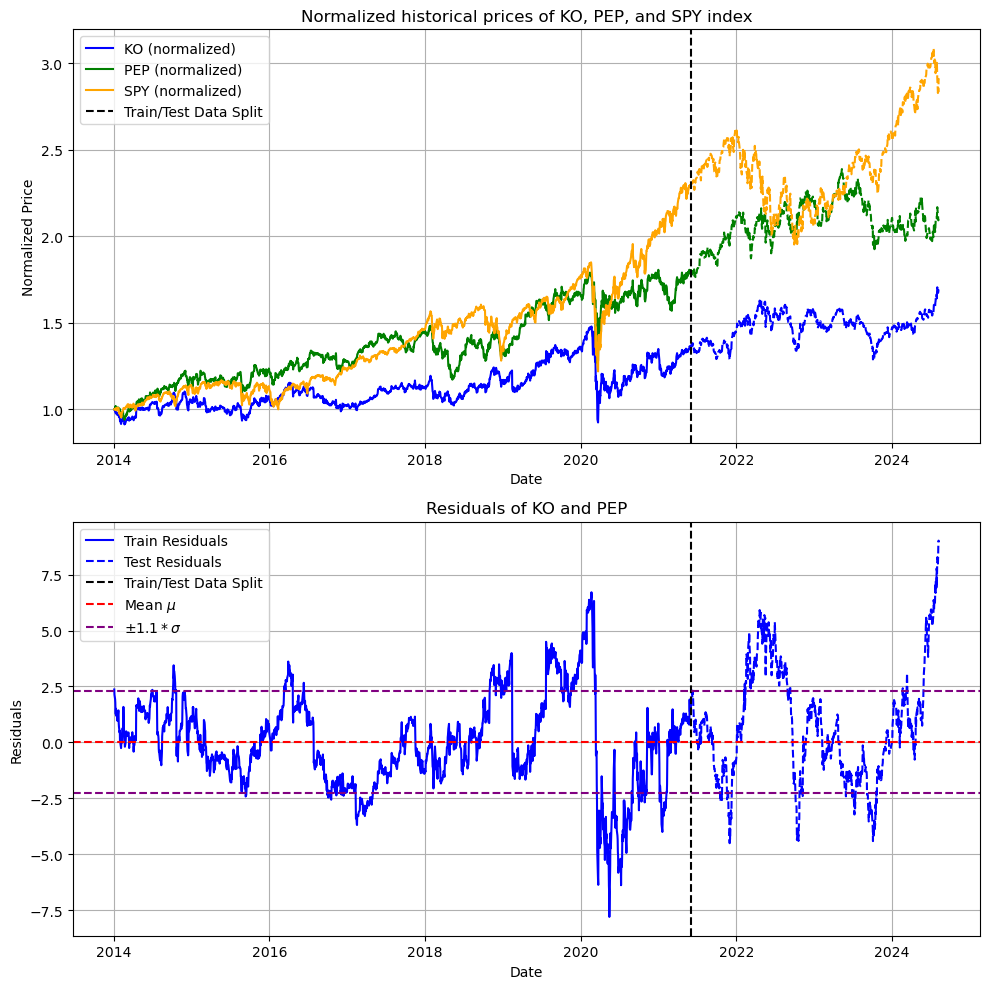

In [20]:
def plot_assets_and_residuals(train_data, test_data, ticker1, ticker2, index_ticker="SPY", split_ratio=0.7):
    plt.figure(figsize=(10, 10))

    # normalize historical prices for train data
    normalized_train_ticker1 = train_data[ticker1] / train_data[ticker1].iloc[0]
    normalized_train_ticker2 = train_data[ticker2] / train_data[ticker2].iloc[0]
    normalized_train_index = train_data[index_ticker] / train_data[index_ticker].iloc[0]

    # normalize historical prices for test data
    normalized_test_ticker1 = test_data[ticker1] / train_data[ticker1].iloc[0]
    normalized_test_ticker2 = test_data[ticker2] / train_data[ticker2].iloc[0]
    normalized_test_index = test_data[index_ticker] / train_data[index_ticker].iloc[0]

    # determine the split date
    split_date = train_data.index[-1]

    # plot normalized prices
    plt.subplot(2, 1, 1)
    plt.plot(train_data.index, normalized_train_ticker1, label=f"{ticker1} (normalized)", color="blue")
    plt.plot(train_data.index, normalized_train_ticker2, label=f"{ticker2} (normalized)", color="green")
    plt.plot(train_data.index, normalized_train_index, label=f"{index_ticker} (normalized)", color="orange")
    
    plt.plot(test_data.index, normalized_test_ticker1, color="blue", linestyle="--")
    plt.plot(test_data.index, normalized_test_ticker2, color="green", linestyle="--")
    plt.plot(test_data.index, normalized_test_index, color="orange", linestyle="--")
    
    plt.axvline(split_date, color="black", linestyle="--", label="Train/Test Data Split")
    plt.title(f"Normalized historical prices of {ticker1}, {ticker2}, and {index_ticker} index")
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.grid(True)

    # plot residuals for train and test data
    plt.subplot(2, 1, 2)
    plt.plot(train_data.index, train_data['residuals'], label="Train Residuals", color="blue")
    plt.plot(test_data.index, test_data['residuals'], label="Test Residuals", color="blue", linestyle="--")
    
    plt.axvline(split_date, color="black", linestyle="--", label="Train/Test Data Split")
    mean = train_data['residuals'].mean()
    stdev = train_data['residuals'].std()
    plt.axhline(mean, color="r", linestyle='--', label=f"Mean $\mu$")
    plt.axhline(mean + 1.1 * stdev, color="purple", linestyle="--", label="$\pm1.1*\sigma$")
    plt.axhline(mean - 1.1 * stdev, color="purple", linestyle="--")
    
    plt.title(f"Residuals of {ticker1} and {ticker2}")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_assets_and_residuals(train_data, test_data, ticker1, ticker2)

In [21]:
def perform_adf_test(residuals, significance_level):
    """Perform the Augmented Dickey-Fuller (ADF) test to check for the presence of unit root in a time series.
    H0: time series has a unit root (i.e. non-stationary)"""
    adf_test = adfuller(residuals)
    adf_statistic, p_value = adf_test[0], adf_test[1]

    print(f"ADF Statistic: {adf_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < significance_level:
        print(f"The residuals are stationary (reject null hypothesis) "
              f"at the {significance_level * 100}% significance level.")
    else:
        print(f"The residuals are not stationary (accept null hypothesis) "
              f"at the {significance_level * 100}% significance level.")
    return adf_test


adf_test_result = perform_adf_test(train_data['residuals'], significance_level=0.05)

ADF Statistic: -3.7958
p-value: 0.0030
The residuals are stationary (reject null hypothesis) at the 5.0% significance level.


#### Conclusion of Engle-Granger Step 1 for the example of KO and PEP

The regression model following $$Y_t = \beta_0 + \beta_1 X_t + e_t$$ yields $$\text{KO}_t = \beta_0 + \beta_1 \text{PEP}_t + e_t$$ with $\beta = \left(\beta_0, \beta_1\right) \approx \left(18.8.9, 0.24\right)$ for our case.**############## Update numbers here**

The Augmented Dickey-Fuller test displayed a very low p-value. We therefore strongly reject the null hypothesis of a unit root at both 5% and 1% significance level, implying that the time series of KO and PEP are cointegrated.

#### Coefficients analysis

$\beta_0$ as the intercept describes the part of KO's price that is independent of PEP.

$\beta_1$ models the linear dependency between KO and PEP in the long-term equilibrium. In practice, this can be used as a hedge ratio, because for every unit change in PEP's price, KO prices will increase by $\beta_1\approx 0.24$**############## Update numbers here** on average.

## Step 2 of Engle-Granger: ECM

The ECM now considers the absolute returns (differences) $\Delta X_t = X_t - X_{t-1}$ (e.g., PEP) and $\Delta Y_t = Y_t - Y_{t-1}$ (e.g., KO). Considering such differences removes long-term continuous effects and is more suitable to analyze short-term dynamics.

The Equilibrium Correction Model (ECM) classically follows the equation
$$\Delta Y_t =\alpha_0+\alpha_1 \cdot \Delta X_t + \alpha_2\cdot e_{t-1}+\varepsilon_t,$$
where
* $e_{t-1}$ denotes the lagged residuals from the previous cointegration regression.
* $\alpha=\left(\alpha_0, \alpha_1, \alpha_2\right)$ is the coefficient of the ECM regression. In particular, $\alpha_2$ is the error correction term coefficient of the residual term $e_{t-1}$, representing the speed of adjustment towards the long-term equilibrium.
* $\varepsilon_t$ denotes the "new" residual terms, inferred from regressing the ECM.

In [22]:
def get_differences(data, columns):
    """Calculate the returns (differences) Delta y_t = y_t-y_{t-1} for the specified columns in the dataframe."""
    return data[columns].diff().dropna()


def fit_ecm(data, residuals_column, target_column, independent_column):
    """Step2 of the Engle-Granger procedure: fit the Equilibrium Correction Model (ECM)."""
    data_delta = get_differences(data, [target_column, independent_column])
    data_delta['lagged_residuals'] = data[residuals_column].shift(1)  # lag the residuals
    data_delta = data_delta.dropna()

    # OLS to obtain ECM coefficients & residuals
    y = data_delta[target_column].values
    X = data_delta[[independent_column, "lagged_residuals"]].values
    ecm_coefficients, ecm_residuals = least_squares_regression(y, X)

    ecm_residuals = pd.DataFrame(ecm_residuals, index=data_delta.index, columns=["ECM_residuals"])  # convert to pd.df
    return {'coefficients': ecm_coefficients, 'residuals': ecm_residuals}


# Fit the ECM for KO and PEP
ecm_results = fit_ecm(train_data, "residuals", ticker1, ticker2)
print("ECM Coefficients:", ecm_results['coefficients'])
print("ECM Residuals:", ecm_results['residuals'])

ECM Coefficients: [-0.00179709  0.27917535 -0.01653346]
ECM Residuals:             ECM_residuals
Date                     
2014-01-03      -0.198161
2014-01-06      -0.164097
2014-01-07      -0.181242
2014-01-08      -0.351949
2014-01-09      -0.076571
...                   ...
2021-05-27       0.978618
2021-05-28      -0.565710
2021-06-01       0.101141
2021-06-02       0.080938
2021-06-03       0.320520

[1867 rows x 1 columns]


### Conclusion of Engle-Granger Step 2 for the example of KO and PEP

The ECM regression for the considered example can be formulated as
$$\Delta\text{KO}_t = \alpha_0 + \alpha_1 \Delta\text{PEP}_t + \alpha_2 e_{t-1} + \varepsilon_t$$
with $\alpha = \left(\alpha_0, \alpha_1, \alpha_2\right) \approx \left(-0.002, 0.279, -0.017\right)$**############### update numbers here!**.

#### Coefficients analysis

$\alpha_1$ is the coefficient that best describes the linear relationship between KO and PEP for shorter-term periods. It signifies that a unit change in $\Delta X_t = \Delta\text{PEP}_t$ results in a $\alpha_1\approx 0.279$**############### update numbers here!** change in $\Delta Y_t = \Delta\text{KO}_t$.

The negative sign of $\alpha_2\approx -0.017$**############### update numbers here!** indicates a mean-reversion towards the long-term mean since it suggests a tendency to correct deviations from the equilibrium.

#### Residuals comparison

While the previously calculated residuals $e_t$ represent deviations from the long-term equilibrium between KO and PEP, the ECM residual time series $\varepsilon_t$ represent deviations in the changes in KO prices after accounting for changes in PEP prices, with short-term dynamics and mean-reverting behavior removed from the model.

Therefore, $\varepsilon_t$ should expectedly be lower in magnitude than the long-term equilibrium residuals $e_t$ and hover closely around $0$ with no obvious patterns - similar to white noise residuals, reflecting that most of the short-term dynamics and mean-reverting corrections to the long-term mean have already been accounted for.

Indeed a plot shows the described behaviour:

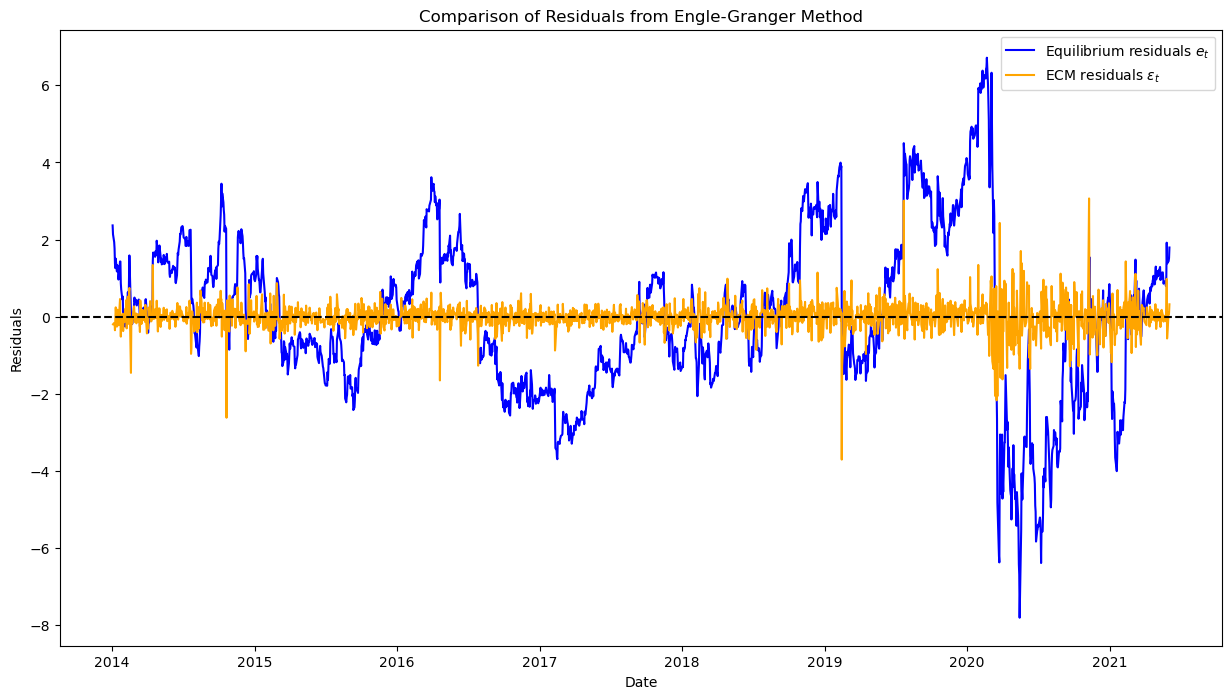

In [23]:
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data['residuals'], label="Equilibrium residuals $e_t$", color="blue")
# Align indices for lagged epsilon residuals
plt.plot(train_data.index[1:], ecm_results['residuals'], label="ECM residuals $\epsilon_t$", color="orange")
plt.axhline(0, color='black', linestyle='--')
plt.title("Comparison of Residuals from Engle-Granger Method")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()

## Step 3 (inofficial): Ornstein-Uhlenbeck process for mean-reverting residuals

$$d e_t = -\theta (e_t - \mu_e) dt + \sigma_{OU} dX_t,$$ where $\theta$ is the speed of mean-reversion to long-term equilibrium mean $\mu_e$ and $\sigma_{OU}$ is the standard deviation (volatility) of the process.


In [24]:
def ou_likelihood(params, residuals, dt):
    """Calculates the negative log-likelihood of an Ornstein-Uhlenbeck process"""
    theta, mu_e, sigma_ou = params
    likelihood = 0
    for t in range(1, len(residuals)):
        mean = residuals[t-1] + theta * (mu_e - residuals[t-1]) * dt
        variance = sigma_ou**2 * dt
        # increment the log likelihood (=log probability density) with mean and variance of the next residual
        likelihood += norm.logpdf(residuals[t], loc=mean, scale=np.sqrt(variance))
    return -likelihood


def estimate_ou_params(residuals, dt=1):  # dt = 1: daily prices, so usually time increment dt = 1
    """Estimate Ornstein-Uhlenbeck process parameters using maximum likelihood estimation.
    The OU process is given as: d(residuals)_t = -theta (residuals_t-mu_e) dt + sigma_ou dX_t"""
    residuals = np.array(residuals)
    initial_params = [0.1, np.mean(residuals), np.std(residuals)]  # [theta0, mu_ou0, sigma_ou0]
    # we minimize negative log-likelihood, which is equivalent to using maximum likelihood estimator (MLE)
    result = minimize(ou_likelihood, initial_params, args=(residuals, dt), method="L-BFGS-B")
    theta, mu_e, sigma_ou = result.x
    return theta, mu_e, sigma_ou


theta, mu_e, sigma_ou = estimate_ou_params(train_data['residuals'])
print(f"Estimated OU parameters: theta={theta:.4f}, mu_e={mu_e:.4f}, sigma_ou={sigma_ou:.4f}")

Estimated OU parameters: theta=0.0173, mu_e=-0.0000, sigma_ou=0.3820


In [25]:
ou_params = {'theta': theta, 'mu_e': mu_e, 'sigma_ou': sigma_ou}

### Visualizing the simulated OU process against the actual residuals $e_t$:

Simulation of Ornstein-Uhlenbeck process with the estimated parameters $(\theta, \mu_e, \sigma_{ou})\approx \left(0.0173, -0.0000, 0.3820\right)$**############### update numbers here!** should display similar dynamics as the ectual residuals time series $e_t$. However, some deviations from the original residual time series $e_t$ are still expected, since the OU process is a continuous-time stochastic process simulated from an SDE including Brownian increments (randomness).

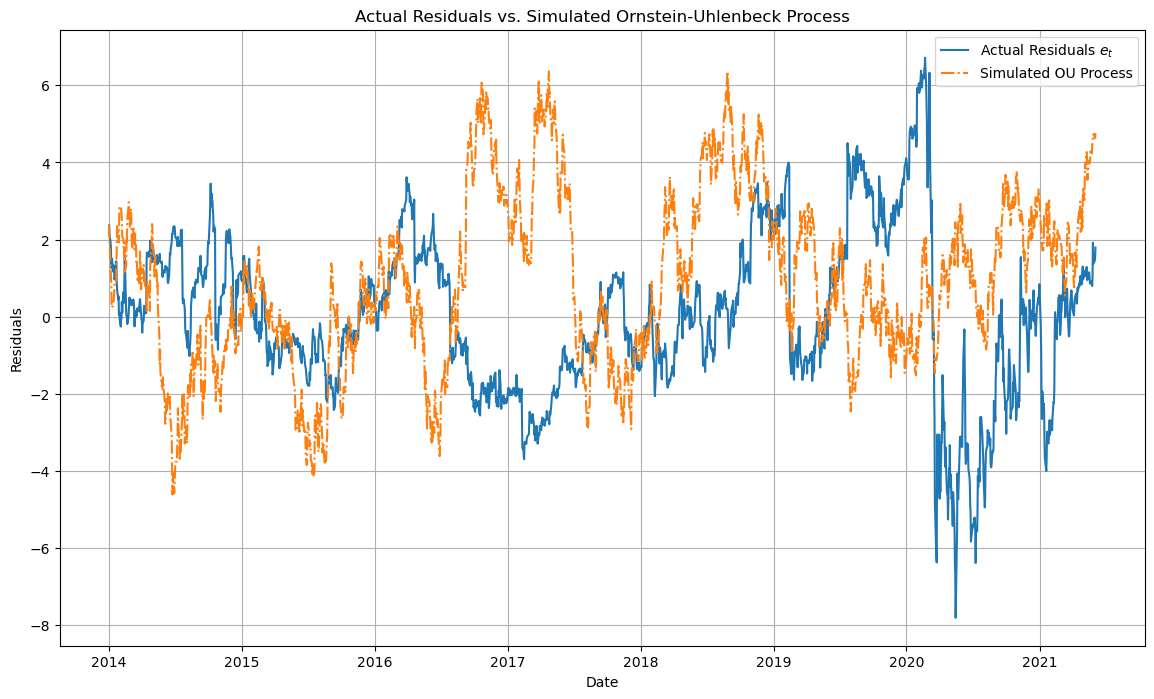

In [26]:
def simulate_ou_process(theta, mu_e, sigma_ou, initial_value, num_steps, dt=1):
    """Simulate an Ornstein-Uhlenbeck process."""
    ou_process = np.zeros(num_steps)
    ou_process[0] = initial_value
    for t in range(1, num_steps):
        ou_process[t] = ou_process[t-1] + theta * (mu_e - ou_process[t-1]) * dt + sigma_ou * np.sqrt(dt) * np.random.normal()
    return ou_process

# Simulate an OU process with the estimated parameters
num_steps = len(train_data['residuals'])
initial_value = train_data['residuals'].iloc[0]
simulated_residuals = simulate_ou_process(theta, mu_e, sigma_ou, initial_value, num_steps)

# Plot the actual residuals and the simulated OU process
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data['residuals'], label="Actual Residuals $e_t$")
plt.plot(train_data.index, simulated_residuals, label="Simulated OU Process", linestyle="-.")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.title("Actual Residuals vs. Simulated Ornstein-Uhlenbeck Process")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
print(f"Half-life of OU process: {np.log(2)/theta:.2f} trading days") 

Half-life of OU process: 40.02 trading days


# Trading strategy based on mean-reversion analysis

Using $\beta_1$ as hedge ratio as previously discussed...

In [30]:
hedge_ratio = beta[1]

In [327]:
class Portfolio:
    def __init__(self, data, ticker1, ticker2, ou_params, hedge_ratio, z):
        self.data = data
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.theta = ou_params['theta']
        self.sigma_ou = ou_params['sigma_ou']
        self.mu_e = ou_params['mu_e']
        self.hedge_ratio = hedge_ratio
        self.z = z
        self.realized_daily_pnl = pd.Series(index=data.index, dtype=float).fillna(0)
        self.unrealized_daily_pnl = pd.Series(index=data.index, dtype=float).fillna(0)
        self.positions = pd.DataFrame(index=data.index, columns=[ticker1, ticker2]).fillna(0)
        self.returns = []
        self.manage_positions()

    def calculate_optimal_bounds(self):
        """Calculate the upper and lower bounds for trading, CQF FP Workshop 2, sl. 15."""
        sigma_eq = self.sigma_ou / np.sqrt(2 * self.theta)
        upper_bound = self.mu_e + self.z * sigma_eq
        lower_bound = self.mu_e - self.z * sigma_eq
        return upper_bound, lower_bound

    def enter_position(self, row, position_ticker1, position_ticker2):
        """Enter a position based on the current market conditions."""
        entry_price_ticker1 = row[self.ticker1]
        entry_price_ticker2 = row[self.ticker2]
        return position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2

    def calculate_trade_pnl(self, row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2):
        """Calculate the PnL of the trade."""
        if position_ticker1 == 1 and position_ticker2 == -self.hedge_ratio:
            trade_pnl = (row[self.ticker1] - entry_price_ticker1) + (entry_price_ticker2 - row[self.ticker2]) * self.hedge_ratio
        elif position_ticker1 == -1 and position_ticker2 == self.hedge_ratio:
            trade_pnl = (entry_price_ticker1 - row[self.ticker1]) + (row[self.ticker2] - entry_price_ticker2) * self.hedge_ratio
        else:
            trade_pnl = 0
        return trade_pnl

    def calculate_unrealized_pnl(self, row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2):
        """Calculate the unrealized PnL for the day based on the movement of ticker1 and ticker2."""
        if position_ticker1 != 0 and position_ticker2 != 0:  # If a position is open
            unrealized_pnl = self.calculate_trade_pnl(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)
        else:
            unrealized_pnl = 0  # No unrealized PnL if no position is open
        return unrealized_pnl

    def append_return(self, trade_pnl, entry_price_ticker1, entry_price_ticker2):
        """Append the return (either simple or log) to the self.returns list."""
        simple_return = trade_pnl / (entry_price_ticker1 + self.hedge_ratio * entry_price_ticker2)
        self.returns.append(simple_return)

    def close_position(self, row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2):
        """Close the position and calculate realized PnL."""
        trade_pnl = self.calculate_trade_pnl(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)
        if trade_pnl != 0:
            self.append_return(trade_pnl, entry_price_ticker1, entry_price_ticker2)
            self.realized_daily_pnl.at[row.name] += trade_pnl  # add realized PnL
        return 0, 0, 0, 0  # reset positions and entry prices

    def manage_positions(self):
        """Manage positions for the trading strategy exploiting mean-reversion of 2 cointegrated assets using
        hedge ratio (beta1) previously obtained in Engle-Granger step 1 and track daily PnL."""
        position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2 = 0, 0, 0, 0
        upper_bound, lower_bound = self.calculate_optimal_bounds()

        # initialize the first value of both daily PnLs to 0
        previous_realized_pnl = 0

        for index, row in self.data.iterrows():
            residual = row['residuals']

            # entry conditions
            if position_ticker1 == 0 and position_ticker2 == 0:
                if residual > upper_bound:  # very positive spread
                    # short ticker1 (over-valued from equilibrium), long ticker2
                    position_ticker1, position_ticker2 = -1, self.hedge_ratio
                elif residual < lower_bound:  # very negative spread
                    # long ticker1 (under-valued from equilibrium), short ticker2
                    position_ticker1, position_ticker2 = 1, -self.hedge_ratio
                position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2 = \
                    self.enter_position(row, position_ticker1, position_ticker2)

            # exit conditions -> close positions
            elif (position_ticker1 == 1 and position_ticker2 == -self.hedge_ratio and residual >= self.mu_e) or \
                    (position_ticker1 == -1 and position_ticker2 == self.hedge_ratio and residual <= self.mu_e):
                position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2 = \
                    self.close_position(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)

            # calculate unrealized PnL for the day
            unrealized_pnl = self.calculate_unrealized_pnl(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)
            self.unrealized_daily_pnl.at[index] = unrealized_pnl

            # carry forward realized PnL
            self.realized_daily_pnl.at[index] += previous_realized_pnl
            previous_realized_pnl = self.realized_daily_pnl.at[index]

            # store the positions for this date
            self.positions.at[index, self.ticker1] = position_ticker1
            self.positions.at[index, self.ticker2] = position_ticker2

    def get_cumulative_pnl(self):
        """Return cumulative realized PnL."""
        return self.realized_daily_pnl.iloc[-1]

    def get_total_pnl(self):
        """Return total PnL, combining realized and unrealized PnL."""
        return self.realized_daily_pnl.add(self.unrealized_daily_pnl, fill_value=0).iloc[-1]


class RiskMetrics:
    def __init__(self, returns):
        self.returns = returns

    def calculate_var(self, confidence_level=0.95):
        """Calculate Value at Risk (VaR) at the given confidence level."""
        if len(self.returns) > 0:
            var = np.percentile(self.returns, (1 - confidence_level) * 100)
        else:
            var = 0
        return var

    def calculate_expected_shortfall(self, confidence_level=0.95):
        """Calculate Expected Shortfall (ES) at the given confidence level."""
        var = self.calculate_var(confidence_level)
        if len(self.returns) > 0:
            expected_shortfall = np.mean([r for r in self.returns if r < var])
        else:
            expected_shortfall = 0
        return expected_shortfall

    def run_full_analysis(self):
        return {'VaR': self.calculate_var(),
                'ES': self.calculate_expected_shortfall()}

In [328]:
def find_best_pnl(pnl_table):
    """In a pnl_table dataframe, find the highest PnL value and its corresponding Z"""
    best_row = pnl_table.loc[pnl_table['PnL'].idxmax()]
    return best_row['Z'], best_row['PnL']


def backtest_strategy_for_z_values(data, ticker1, ticker2, ou_params, hedge_ratio, z_values, plotting=False):
    """Test Z values in range of z_values (iterable) and calculate Pnl for every Z value."""
    results = []
    for z in z_values:
        portfolio = Portfolio(data, ticker1, ticker2, ou_params, hedge_ratio, z)
        pnl = portfolio.get_cumulative_pnl()
        risk_metrics = RiskMetrics(portfolio.returns)
        metrics = risk_metrics.run_full_analysis()
        results.append({'Z': z, 'PnL': pnl, **metrics})
    results_df = pd.DataFrame(results)
    best_z, best_pnl = find_best_pnl(results_df)
    if plotting:
        plot_pnl_table(results_df, best_z, best_pnl)
    return results_df, best_z


def plot_pnl_table(pnl_table, best_z, best_pnl):
    """Plot the PnL values achieved for different Z-values. Mark the best Z-value with a star."""
    plt.figure(figsize=(10, 6))
    plt.plot(pnl_table['Z'], pnl_table['PnL'], marker="o", linestyle="-", color="b", label="PnL vs Z")

    # Highlight the best PnL point with a star
    plt.scatter(best_z, best_pnl, color='r', marker="*", s=100, zorder=5,
                label=f"Best PnL: {best_pnl:.2f} at Z={best_z:.2f}")

    # Add text annotation to best PnL
    plt.text(best_z, best_pnl, f"  Z={best_z:.1f}\n  PnL={best_pnl:.1f}", color="r", bbox=dict(facecolor="white"))

    plt.title("PnL vs Z")
    plt.xlabel("Z")
    plt.ylabel("PnL")
    plt.grid(True)
    plt.show()

### Backtesting: in-sample performance evaluation on `train_data`

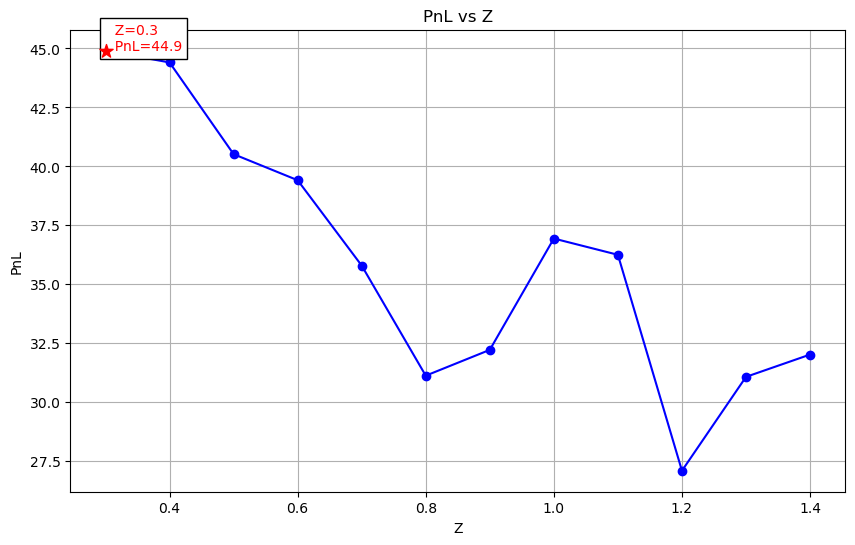

In [331]:
# Backtesting: in-sample performance evaluation on train_data
test_z_values = np.arange(0.3, 1.5, 0.1)
train_results, z_best = backtest_strategy_for_z_values(train_data, ticker1, ticker2, ou_params, hedge_ratio,
                                                       z_values=test_z_values, plotting=True)

In [332]:
train_results

,Z,PnL,VaR,ES
0,0.3,44.902131,0.009799,0.008908
1,0.4,44.405114,0.012959,0.012480
2,0.5,40.518220,0.016892,0.016468
3,0.6,39.414290,0.018776,0.018026
4,0.7,35.795723,0.019819,0.018026
5,0.8,31.130518,0.024898,0.024131
6,0.9,32.224748,0.026606,0.025312
7,1.0,36.942552,0.029557,0.027469
8,1.1,36.253553,0.033331,0.033072
9,1.2,27.102763,0.034244,0.033072


### Backtesting: out-of-sample performance evaluation on `test_data`

This emulates the real-world example where one would have conceived this trading strategy mid-2021 after observing around 7 years of prices. Testing it for the last 3 years up until August 2024 data yields the following performance:

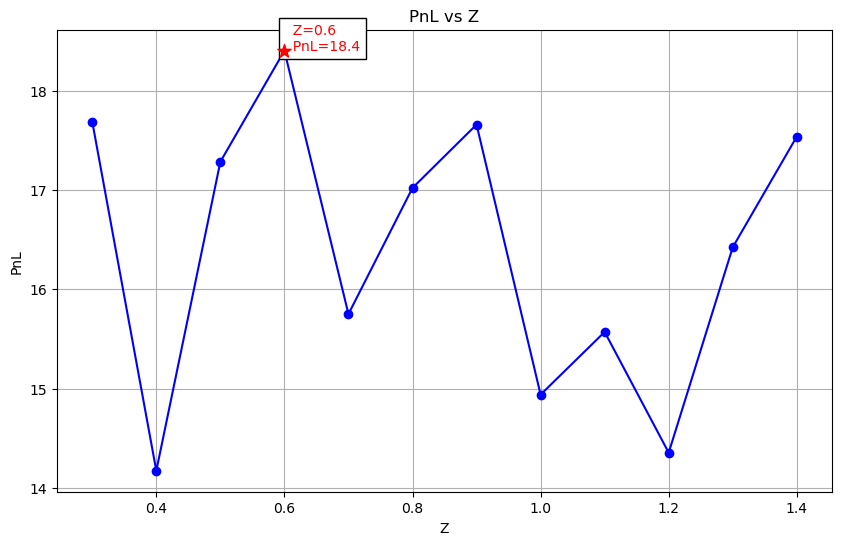

In [333]:
# Backtesting: out-of-sample performance evaluation on test_data
test_results, _ = backtest_strategy_for_z_values(test_data, ticker1, ticker2, ou_params, hedge_ratio,
                                                 z_values=test_z_values, plotting=True)

In [334]:
test_results

,Z,PnL,VaR,ES
0,0.3,17.689561,0.007321,0.006955
1,0.4,14.173060,0.009216,0.008892
2,0.5,17.285605,0.011424,0.010967
3,0.6,18.404541,0.013157,0.012823
4,0.7,15.751595,0.014203,0.013566
5,0.8,17.022272,0.017233,0.017192
6,0.9,17.660445,0.019563,0.019345
7,1.0,14.939584,0.021493,0.020325
8,1.1,15.571545,0.023871,0.023496
9,1.2,14.354814,0.025059,0.024376


We see that the choice of `z_best=0.3` would not have been optimal in for our test data set, but we shall still move forward with this Z-value, since I want to simulate the data split as realistically as possible. 

In [378]:
portfolio = Portfolio(test_data, ticker1, ticker2, ou_params, hedge_ratio, z=z_best)

In [379]:
# portfolio.positions["2022-09-20":]
portfolio.realized_daily_pnl["2022-03-20":]

Date
2022-09-20     5.505894
2022-09-21     5.505894
2022-09-22     5.505894
2022-09-23     6.438723
2022-09-26     6.438723
                ...    
2024-08-05    17.689561
2024-08-06    17.689561
2024-08-07    17.689561
2024-08-08    17.689561
2024-08-09    17.689561
Length: 475, dtype: float64

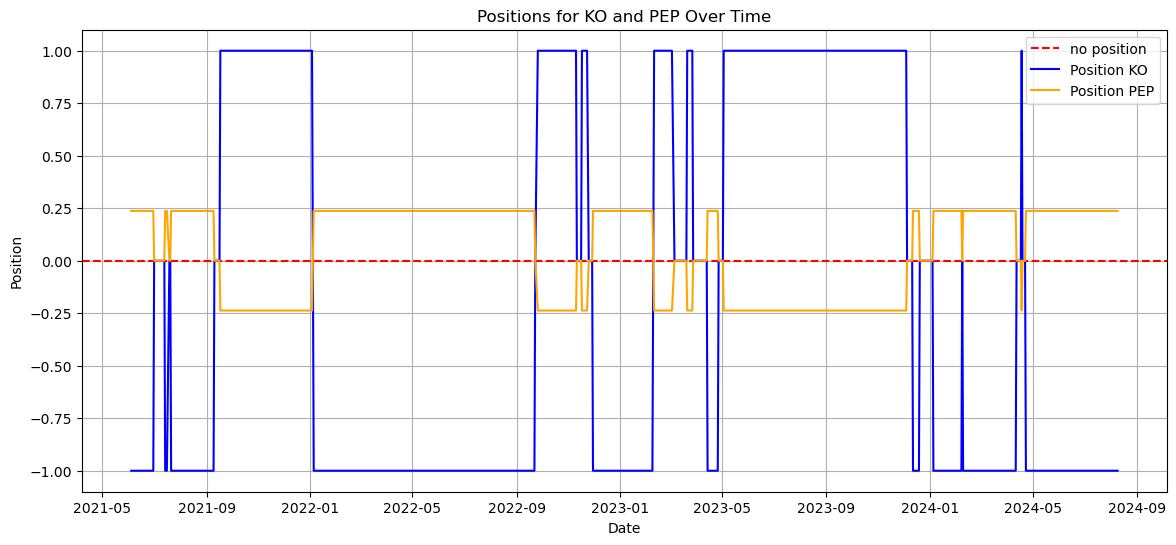

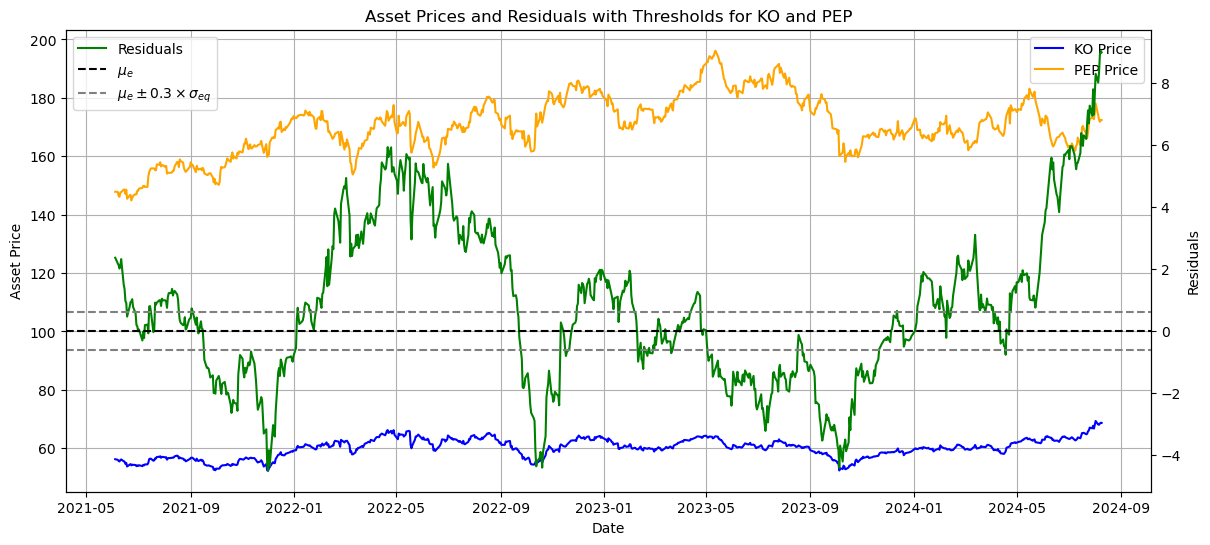

In [376]:
def plot_positions(portfolio):
    """Plot the positions of ticker1 and ticker2 over time."""
    dates = portfolio.data.index

    plt.figure(figsize=(14, 6))
    plt.axhline(0, color="r", linestyle="--", label="no position")
    plt.plot(dates, portfolio.positions[portfolio.ticker1], label=f"Position {portfolio.ticker1}", color="blue")
    plt.plot(dates, portfolio.positions[portfolio.ticker2], label=f"Position {portfolio.ticker2}", color="orange")
    plt.xlabel("Date")
    plt.ylabel("Position")
    plt.title(f"Positions for {portfolio.ticker1} and {portfolio.ticker2} Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_asset_prices_and_residuals(portfolio):
    """Plot the asset prices and residuals with sigma_eq-bands using subplots."""
    dates = portfolio.data.index

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # primary y-axis: asset prices
    ax1.plot(dates, portfolio.data[portfolio.ticker1], label=f"{portfolio.ticker1} Price", color="blue")
    ax1.plot(dates, portfolio.data[portfolio.ticker2], label=f"{portfolio.ticker2} Price", color="orange")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Asset Price")
    ax1.legend()
    ax1.grid(True)

    # secondary y-axis: residuals
    ax2 = ax1.twinx()
    ax2.plot(dates, portfolio.data['residuals'], label="Residuals", color="green")
    ax2.axhline(portfolio.mu_e, color="black", linestyle="--", label=r"$\mu_e$")
    upper_bound, lower_bound = portfolio.calculate_optimal_bounds()
    sigma_band_label = r"$\mu_e \pm " + str(portfolio.z) + r" \times \sigma_{eq}$"
    ax2.axhline(upper_bound, color="grey", linestyle="--", label=sigma_band_label)
    ax2.axhline(lower_bound, color="grey", linestyle="--")
    ax2.set_ylabel("Residuals")
    ax2.legend()

    plt.title(f"Asset Prices and Residuals with Thresholds for {portfolio.ticker1} and {portfolio.ticker2}")
    plt.show()


plot_positions(portfolio)
plot_asset_prices_and_residuals(portfolio)

In [341]:
# Cumulative realized PnL
cumulative_pnl = portfolio.get_cumulative_pnl()
print(f"Cumulative Realized PnL: {cumulative_pnl}")

# Total PnL (realized + unrealized)
total_pnl = portfolio.get_total_pnl()
print(f"Total PnL (Realized + Unrealized): {total_pnl}")

Cumulative Realized PnL: 5.115315230645017
Total PnL (Realized + Unrealized): 1.5647598137284708


We will now compare this portfolio against the index by plotting both the piece-wise constant realized PnL as well as the continuous unrealized PnL. These will be compared against a benchmark trading strategy where one would simply hold the equity index. To ensure that the scaling is comparable, we will scale the index returns to reflect the initial dollar investment in the cointegration portfolio.

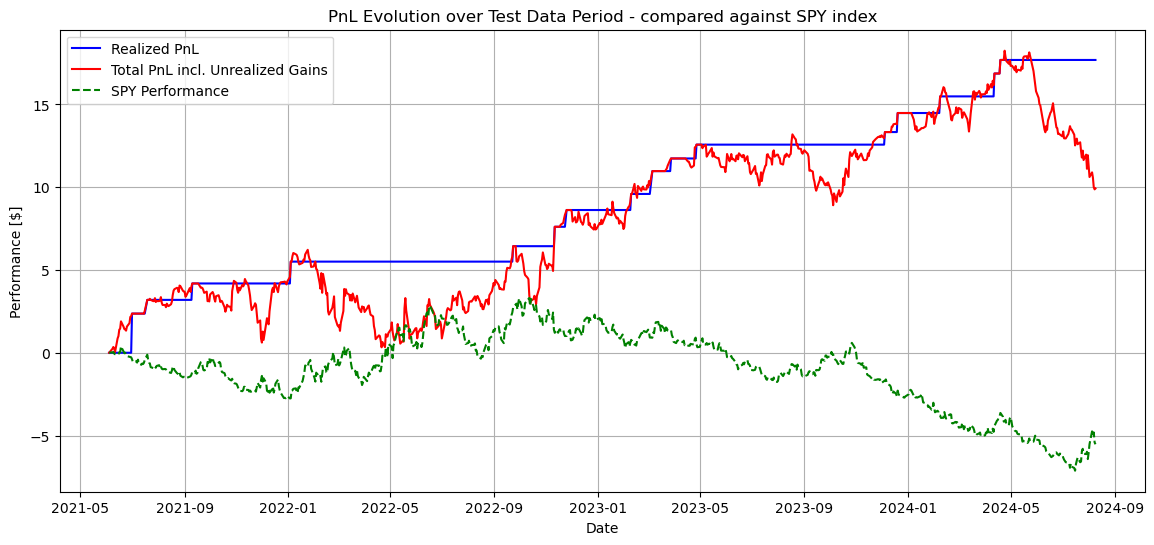

In [423]:
def get_portfolio_investment(portfolio):
    """Calculate the initial dollar investment in the portfolio."""
    ticker1 = portfolio.ticker1
    ticker2 = portfolio.ticker2

    # boolean series for non-zero positions in ticker1 and ticker2
    condition_ticker1 = portfolio.positions[ticker1] != 0
    condition_ticker2 = portfolio.positions[ticker2] != 0
    combined_condition = np.logical_or(condition_ticker1, condition_ticker2)

    # find index of the first non-zero position
    first_trade_date_idx = portfolio.positions[combined_condition].index[0]

    # entry prices at first trade date
    entry_price_ticker1 = portfolio.data.loc[first_trade_date_idx, ticker1]
    entry_price_ticker2 = portfolio.data.loc[first_trade_date_idx, ticker2]
    
    # positions of first trade date
    position_ticker1 = portfolio.positions.loc[first_trade_date_idx, ticker1]
    position_ticker2 = portfolio.positions.loc[first_trade_date_idx, ticker2]
    return entry_price_ticker1 * position_ticker1 + entry_price_ticker2 * position_ticker2


def plot_pnl_against_index(portfolio, index_ticker):
    """Plot the portfolio PnL compared to index performance."""
    realized_pnl = portfolio.realized_daily_pnl
    total_pnl = portfolio.unrealized_daily_pnl + portfolio.realized_daily_pnl
    dates = portfolio.data.index

    # Calculate the cumulative return of the index and scale to portfolio investment
    index_prices = portfolio.data[index_ticker]
    initial_index_price = index_prices.iloc[0]
    normalized_index_return = (index_prices - initial_index_price) / initial_index_price
    index_return_scaled = normalized_index_return * get_portfolio_investment(portfolio)

    plt.figure(figsize=(14, 6))
    plt.plot(dates, realized_pnl, label="Realized PnL", color="blue")
    plt.plot(dates, total_pnl, label="Total PnL incl. Unrealized Gains", color="red")
    plt.plot(dates, index_return_scaled, label=f"{index_ticker} Performance", color="green", linestyle="--")
    plt.title(f"PnL Evolution over Test Data Period - compared against {index_ticker} index")
    plt.xlabel("Date")
    plt.ylabel("Performance [$]")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_pnl_against_index(portfolio, index_ticker="SPY")

The index returns seem to decline over time which seems counter-intuitive upon first inspection. However, this is due to the fact that the cointegration portfolio value we are comparing against actually started out negative, since the short position was larger in absolute terms than the long position in the beginning. In this case, the trading strategy (starting with a short position) was more beneficial than shorting the index.